# Titanic Project

In this notebook, I am working on Kaggle's Titanic dataset to find patterns in the passenger data in the hope to discover certain features that improved the likelihood of survival. This notebook is inspired by work done by others, including Youtuber Ken Jee's 'Beginner Kaggle Data Science Project Walk-Through' video, and help from data scientist friends of mine; a particularly special thanks to my close friend Scott Vinay. I understand all code executed below and feel comfortable replicating similar work in future.

In [1]:
# Importing modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re
from collections import defaultdict
from scipy.spatial.distance import cdist

# Sklearn predictive model modules
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Useful finder function
def find(s, ch):
    return np.array([i for i, ltr in enumerate(s) if ltr == ch]).astype(int)

# Initial Data Exploration and Visualisation

### Basic Dataframe Processing

In the cell below, I do some initial processing of the dataframe. I make all columns lower case and replace any spaces with underscores for easy and consistent referencing. As 'passengerid' is simply another index, it is unnecessary and I remove it.

To separate the training and cross validation data, I create a new column, 'train'. If a row has a train entry of 1, this is training data. If the entry is 0, this is cross validation data. I do a random permutation of indexing so to vary the subsets of training and validation data used.

In [2]:
# Loading data
def load(mode='train'):   
    """
    Loads dataframe from CSV file and performs initial processing.
    
    Parameters
    ---------
        mode : str
            By default 'train'. Options:
            'train': Loads training data.
            'test' : Loads testing data.
            
    Returns
    -------
        Processed DataFrame.
    """
    
    # Loads dataframe as either training or test data
    if mode=='train':
        df = pd.read_csv('train.csv')
    elif mode=='test':
        df = pd.read_csv('test.csv')
    else:
        raise NotImplementedError
        
    # Initial dataframe processing
    df      = df.rename(columns = {c:c.lower().replace(' ', '_') for c in df.columns})
    df      = df.drop(columns = ['passengerid'])
    df_cols = list(df.columns)
    
    # Creating 'train' column to separate training and validation data
    indices = np.random.permutation(df.index)
    tr_ind  = indices[:int(len(indices)*0.75)]
    cv_ind  = indices[int(len(indices)*0.75):]
    df.loc[tr_ind, 'train']=1
    df.loc[cv_ind, 'train']=0
    
    return df

### First Look at Dataframe

In [3]:
# Loading dataframe
df = load()
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,train
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1.0


### Data Types and Null Values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
 11  train     891 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 83.7+ KB


In [5]:
# Isolating features containing null values
nan_features = []
for c in df.columns:
    if df[c].isnull().values.any(): 
        nan_features.append(c)

# Percentage of NaNs for each column with null values
for nf in nan_features:
    nan_percent = 100*df[nf].isnull().sum() /len(df)
    print('The feature',nf,f'is {nan_percent:.3} percent NaN values')

The feature age is 19.9 percent NaN values
The feature cabin is 77.1 percent NaN values
The feature embarked is 0.224 percent NaN values


### Numeric Column Statistics

In [6]:
df.describe()

,survived,pclass,age,sibsp,parch,fare,train
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.749719
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.433418
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.500000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [7]:
# Separating into numeric and categorical data
num_cols = ['age', 'sibsp', 'parch', 'fare']
cat_cols = ['survived', 'pclass', 'name', 'sex', 'ticket', 'cabin', 'embarked']

# Separating into numeric and categorical dataframes
df_num = df[num_cols]
df_cat = df[cat_cols]

### Basic Visualisation

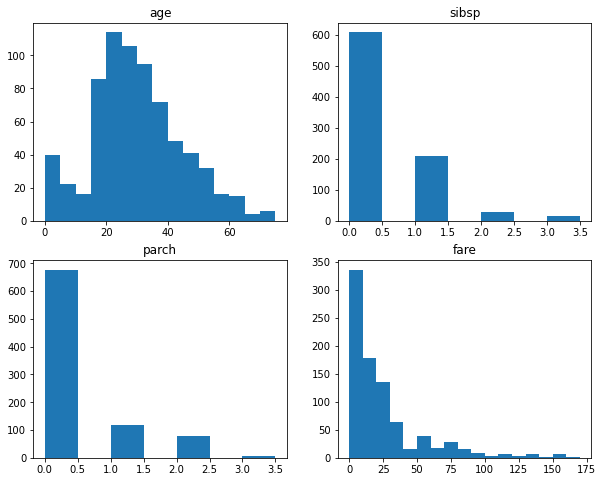

In [8]:
# Histogram subplot visualisation of numeric columns
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=[10,8])
axes = axes.flatten()

# Visualisation
count=0
for ax in axes:
    col = num_cols[count]
    bins_=[np.arange(0,80,5), np.arange(0,4,0.5), np.arange(0,4,0.5), np.arange(0,175,10), ]
    ax.hist(df_num[col],bins=bins_[count])
    ax.set_title(col)
    count+=1

To make the fare distribution more uniform I will take the logarithm of that feature.

Model might be improved to group sibsp and parch by 0 and 1 or more.

In [9]:
df['fare'] = np.log(df.fare+1)

# Processing Dataframe

### Function To Sort Null Values

The code below is used to evaluate the null values. The null evaluation types I have used below are:

1 - Zero: 
This method sorts all null values in the dataframe to zero.

2 - Mean: 
This method calculates the mean of a column using the training data. Then it applies the mean to all null values in the training and cross validation data.

3 - Nearest Neighbour:
This method creates a symmetric 2x2 matrix of distances, that is the distance, or similarity, between each of the rows. First, you identify which column contains null values, e.g. column x. Next, you create the distance matrix using all columns except for column x. Next, you find the row, e.g. row i, that contains the null value. Following this, you look at row i in the distance matrix and identify the smallest value, which is given at position i,j. Then you replace the null value in row i, column x with the value in row j, column x. This process repeats until all null values are replaced with the value of the row that is most similar to itself. 

There are many different metrics to calculate the distance between rows, here below I've used seuclidean which is the standardised euclidean distance. This differs from the regular euclidean distance by standardising the columns before calculating the distances.

Note: naturally the distance matrix has a trace of zero (zeros along the diagonal) so I've set the diagonal values to purposefully large values to prevent the code from selecting diagonal values as the shortest distance.

In [10]:
# Function to sort the null values 
def sortnull(df, mode = 'zero'):
    """
    Sorts null values of a dataframe.
    
    Parameters
    ---------
        df : DataFrame
            Dataframe that contains null values to be sorted.
            
        mode : By default 'zero'. Options:
            'zero': Sorts null values into zeros.
            'mean': Sorts null values using the mean.
            'near': Sorts null values using the nearest neighbour algorithm
                    on the rows.
    Returns
    -------
        DataFrame with no null values.
    """
    
    if mode=='zero':
        df = df.fillna(0)

    if mode=='mean':
        # Mean of the nf column in training dataframe (don't use cv dataframe as this fits data to cv data)
        mean      = df.loc[df['train']==1, 'age'].mean()
        df['age'] = df['age'].fillna(mean)

    # Using nearest neighbours to sort null values
    if mode=='near':
        df_cols = ['sex', 'sibsp', 'parch', 'fare', 'embarked_C', 'embarked_Q',
                   'embarked_S', 'pclass_1', 'pclass_2', 'pclass_3']

        # Creating distance matrix to find nearest neighbours
        dists   = cdist(df[df_cols].values, df[df_cols].values, 'seuclidean')
        dists   = dists + 1e5*np.identity(dists.shape[0])
        
        # Locates indices of null values
        null_idx     = df.loc[pd.isna(df['age']), :].index
        non_null_idx = df.loc[~pd.isna(df['age']), :].index

        # Loops through rows containing null values
        for i in null_idx:
            # Distances
            distances = list(dists[i, :])
            distance_idx_sorted = sorted(
                                  range(len(distances)), 
                                  key=lambda j: distances[j])
            for k in range(len(distances)):
                if np.isnan(df.loc[k, 'age']) == True:
                    continue
                else:
                    df.loc[i, 'age'] = df.loc[k, 'age']
                    break 

    return df

### Processing Function

The process function below manipulates the columns into a way that allows data science to be done with it. 

I converted the 'sex' column of male/female into binary 1,0. 

I noticed that the ages of people with master as their title was lower than the dataframe mean age. I isolated the ages containing master in the title, calculated their mean and replaced the null values in this subset with this mean.

I one-hot encoded the columns 'embarked' and 'pclass'. This separates these individual columns into n columns, where n is the number of unique values in each column. E.g. the pclass column had entries {1, 2, 3} depending on the ticket class the individual had. After one-hot encoding there are three separate columns: pclass_1, pclass_2 and pclass_3. In a row where pclass is equal to 1, pclass_1 has an entry of 1 and the other columns have an entry of 0 etc. The same thing is done to the embarked column.

Next, I make use of the sortnull function above to take any null values left remaining in the processed dataframe to be replaced. This allows us to use all the rows in the data to make predictions. 

In [11]:
# Processing the dataframe
def process(df, sortnull_mode='zero'):
    """
    Processes inputted dataframe into format that allows for data science.
    
    Parameters
    ---------
        df : DataFrame
            Dataframe that requires processing.
            
        sortnull_mode : By default 'zero'. Options:
            'zero': Sorts null values into zeros.
            'mean': Sorts null values using the mean.
            'near': Sorts null values using the nearest neighbour algorithm
                    on the rows.
    Returns
    -------
        dftr : DataFrame
            Training dataframe, used to train the predictive model.
        dfcv : DataFrame
            Cross validation dataframe, used to make and compare predictions
            to test predictive models.
        features : list of strings.
    """
    
    # Sorting gender column
    if 'male' in df['sex'].values:
        df['sex'] = (df['sex']=='male').astype(int).values
    
    # Sorting age null values using entries in name col containing str 'Master' 
    masterAge_mean = df['age'].loc[df['name'].str.contains('Master')].mean()
    masterAge_mean = round(masterAge_mean, 2)
    df['age'].loc[df['name'].str.contains('Master')] = df['age'].loc[df['name'].str.contains('Master')].fillna(masterAge_mean)
    df.loc[df['name'].str.contains('Master'), 'age'] = df.loc[df['name'].str.contains('Master'), 'age'].fillna(masterAge_mean)
    
    # One-hot encoding 'embarked', 'pclass' columns
    # Embarked column
    df.dropna(subset=['embarked'])
    df_embarked   = pd.get_dummies(df.embarked)
    embarked_cols = list(df_embarked.columns)
    df_embarked = df_embarked.rename(columns = {c: f'embarked_{c}' for c in embarked_cols})
    
    # pclass column
    df_pclass   = pd.get_dummies(df.pclass)
    pclass_cols = list(df_pclass.columns)
    df_pclass   = df_pclass.rename(columns = {c: f'pclass_{c}' for c in pclass_cols})

    # Removing unnecessary columns
    removed_cols = ['name','ticket','embarked','pclass','cabin', 'cabin_number','survived']
    df = pd.concat([df, df_embarked, df_pclass], axis=1)
    df = df[[c for c in df if c not in removed_cols] + ['survived']]
    
    # Sorting null values using sortnull
    df = sortnull(df, sortnull_mode)
    
    # Feature scaling: normalisation
    for nf in num_cols:
        col = df.loc[df['train']==1, nf]
        num_col_mean = col.mean()
        num_col_std  = col.std()
        df[nf] = (df[nf] - num_col_mean)/num_col_std
        
    # Separating into training and cross validation data
    dftr = df[df['train']==1]
    dfcv = df[df['train']==0]
    
    # Removing 'train' column
    df = df.drop(columns = ['train'])
    
    # Finding features
    features = df.columns[:-1]

    return dftr, dfcv, features

# Loading Dataframes and Defining Models

### Loading Data

In [12]:
# Training and cross validation data and features
dftr_near, dfcv_near, features = process(df, sortnull_mode = 'near')
dftr_mean, dfcv_mean, features = process(df, sortnull_mode = 'mean')
dftr_zero, dfcv_zero, features = process(df, sortnull_mode = 'zero')

# X training data
Xtr_near = dftr_near[features].values
Xtr_mean = dftr_mean[features].values
Xtr_zero = dftr_zero[features].values
# X cross validation data
Xcv_near = dfcv_near[features].values
Xcv_mean = dfcv_mean[features].values
Xcv_zero = dfcv_zero[features].values

# X data dictionary
X_modes = {
    'Near': [Xtr_near, Xcv_near],
    'Mean': [Xtr_mean, Xcv_mean],
    'Zero': [Xtr_zero, Xcv_zero]}

# y outputs (dftr_mean=dftr_zero and dfcv_mean=dfcv_zero as these values aren't changed by sorting nans)
ytr = dftr_mean['survived'].values
ycv = dfcv_mean['survived'].values

C:\Users\micha\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-e53ae1ae557d>:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'male' in df['sex'].values:
C:\Users\micha\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-e53ae1ae557d>:27: FutureWarning: elementwise comparison failed; returning scalar instead, b

### Defining the Predictive Models

In [13]:
# Creating models
model_rf = RandomForestClassifier()
model_gb = GradientBoostingClassifier()
model_lr = LogisticRegression(max_iter=1e5)

# Models dictionary
models = {
    'Random Forest': model_rf,
    'Gradient Boosting': model_gb,
    'Logistic Regression': model_lr}

# Results

### Get Result Function

The function below receives the models and the data and produces the the results, which indicate how well the models do when predicting the outcome on the cross validation set. The models are first created using the training data, (Xtr, ytr), and then use the cross validation input data, Xcv, to make predictions on the outcome, y_pred. These predictions are then compared directly to the true cross validation output data, ycv, and return a single value metric that allows easy comparison between the different models and null value evaluation types. The two metrics I have used below are the F1 score and the accuracy. 

In [14]:
def get_results(models, X_modes, ytr, ycv):
    """
    Processes inputted dataframe into format that allows for data science.
    
    Parameters
    ---------
        models : dict
            Dictionary containing predictive models.
        X_modes : dict
            Dictionary containing input training and cross validation
            data for different null evaluation types.
        ytr : numpy.ndarray
            Array containing output training data.
        ycv : numpy.ndarray
            Array containing output cross validation data.
    Returns
    -------
        df_results : DataFrame
            Dataframe containing the results for the models
            and data inputted.
    """
    
    # Creating empty dictionary
    data = defaultdict(list)
    
    # Looping through each model
    for m in models.keys():
        model      = models[m]
        # Looping through each set of X data
        for x in X_modes.keys():
            # Fitting model to X,y training data
            X = X_modes[x][0]
            y = ytr
            model.fit(X,y)
            
            # y prediction using cross validation data
            y_pred = model.predict(X_modes[x][1])
            
            # Evaluation metrics
            acc    = accuracy_score(y_pred,ycv)
            f1     = f1_score(y_pred,ycv)
            
            # Appending values to dataframe
            data['model']   .append(m)
            data['mode']    .append(x)
            data['accuracy'].append(acc)
            data['f1']      .append(f1)
            
            # Creating dataframe of results
            df_results = pd.DataFrame(data)
            
    return df_results

### Results Dataframe

In [15]:
# Dataframe of models, null evaluation types and metric scores
df_results = get_results(models, X_modes, ytr, ycv)
df_results

,model,mode,accuracy,f1
0,Random Forest,Near,0.834081,0.741259
1,Random Forest,Mean,0.829596,0.739726
2,Random Forest,Zero,0.843049,0.761905
3,Gradient Boosting,Near,0.834081,0.751678
4,Gradient Boosting,Mean,0.852018,0.781457
5,Gradient Boosting,Zero,0.843049,0.758621
6,Logistic Regression,Near,0.793722,0.712500
7,Logistic Regression,Mean,0.802691,0.725000
8,Logistic Regression,Zero,0.811659,0.727273


### Best Result Function

This function searches the results dataframe above to extract the best model, null evaluation type and metric score so that it doesn't have to do be done manually. It searches one of the metric columns, finds the maximum value and the index at which the maximum value occurs. It then uses the index to extract the model and mode that correspond to that maximum value.

In [16]:
def finding_best_results(df, metric):
    
    best_score = df_results[metric].max()
    idx        = df_results[metric].idxmax()
    best_model = df_results.loc[idx, 'model']
    best_mode  = df_results.loc[idx, 'mode']
    
    return best_model, best_mode, best_score

### Displaying Best Results

In [17]:
best_f1  = finding_best_results(df, 'f1')
best_acc = finding_best_results(df, 'accuracy')
print(best_f1)

('Gradient Boosting', 'Mean', 0.781456953642384)


# Visualising Results

The plotter function recieves the results dataframe and plots them in an easily understood bar chat. The models are separated by spaces and the different null value evaluation tpyes are colours.

In [18]:
def plotter(df, metric='f1'):
    """
    Plots the results of a results dataframe.
    
    Parameters
    ---------
        df : DataFrame
            Dataframe of results.
        metric : str
            By default 'f1'. Options:
                'f1': F1 score.
                'accuracy': accuracy score.
    Returns
    -------
    
    """

    # General figure configuration
    plt.figure(figsize=(10,5))
    sns.set(font_scale=2)
    
    # Creating lists from dataframe
    models         = df['model'].unique()
    nan_eval_types = df['mode'].unique()
    
    # Model separation on graphs
    main_ticks = np.arange(len(models))
    jump = 1/(len(nan_eval_types)+1)
    
    # Looping through each null value evaluation type
    for i, net in enumerate(nan_eval_types):
        xpos = main_ticks + jump*i
        plot_data = [df.loc[(df['model']==mod) &
                            (df['mode']==net),
                            metric].values[0] for mod in models]
        
        # Plotting bar charts
        plt.bar(xpos,
               plot_data,
               width = jump*0.9,
               label = net.title())
    
    # Customisation with more specifc customisation depending on metric used
    if metric == 'f1':
        plt.ylabel(r'$F_1$ score')
        plt.title(r'Titanic $F_1$ Scores')
    if metric == 'accuracy':
        plt.ylabel('Accuracy')
        plt.title('Titanic Accuracy Scores')
    plt.gca().set_xticks(main_ticks + jump*(i/2))
    plt.gca().set_xticklabels(models)
    legend = plt.legend(title='Null Value Processing Type', loc=[1.01,0.65])
    plt.setp(legend.get_title(), fontsize=14)
    plt.grid(axis='x')
    # plt.ylim([0,1])
    plt.show()

### Visualising Final Results Using Evaluation Metrics

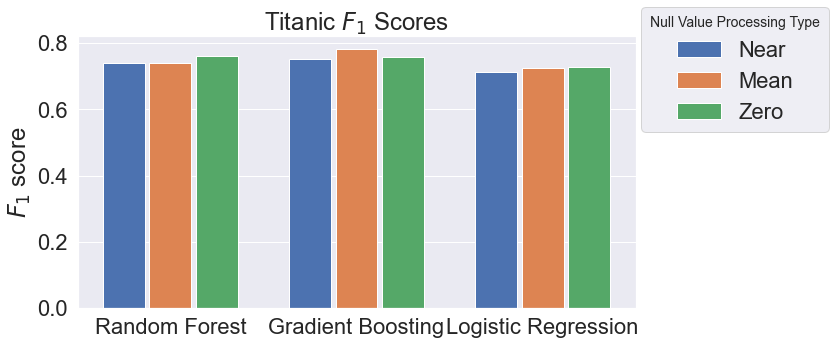

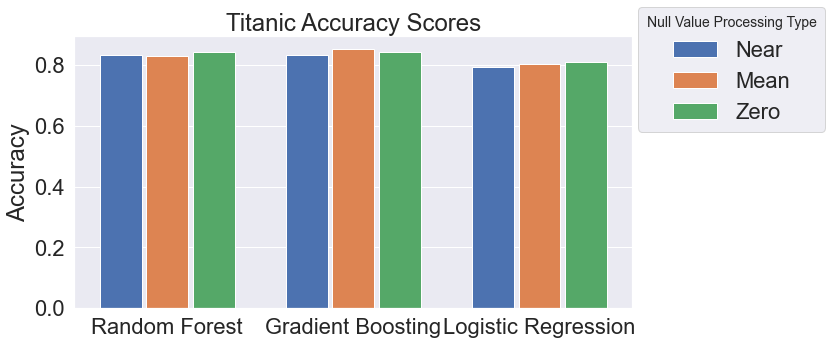

In [19]:
plotter(df_results)
plotter(df_results, metric='accuracy')